In [19]:
# Biblioteki
import os
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array, array_to_img
%matplotlib inline

In [2]:
# Funkcja z zajęć do pobierania obrazków
def load_images(img_dir, n_images=1000, resize=(50, 50)):
    from keras.preprocessing.image import load_img, img_to_array

    images = os.listdir(img_dir)
    dog = np.array(['dog' in img for img in images])
    n_per_categ = n_images // 2

    n_stars = 0
    imgs, y = list(), list()
    for flt_idx, flt in enumerate([~dog, dog]):
        sel_images = np.array(images)[flt]
        np.random.shuffle(sel_images)
        for idx in range(n_per_categ):
            full_img_path = os.path.join(img_dir, sel_images[idx])
            imgs.append(img_to_array(load_img(full_img_path,
                                              target_size=resize)))
            y.append(flt_idx)

            # progressbar
            if idx % 20 == 0:
                print('*', end='')
                n_stars += 1
            if n_stars == 50:
                n_stars = 0
                print('')

    y = np.array(y)
    imgs = np.stack(imgs, axis=0)
    return imgs, y

In [3]:
# Pobieranie obrazków
dir = 'train'
X, y = load_images(dir, n_images=25000, resize=(75, 75))

**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
**************************************************
*******************************

In [10]:
# Podział obrazków na zbiór testowy i treningowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=23)

In [11]:
# Biblioteki do tworzenia modelu
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model

In [12]:
# Do tworzenia sieci neuronowej użyję modelu InceptionV3, często stosowanego w przypadku klasyfikacji obrazów
pre_trained = InceptionV3(input_shape=(75,75,3), include_top=False, weights='imagenet')

In [13]:
# Dodawanie ostatniej warstwy, gdyż z gotowego modelu należało ją usunąć, gdyż była przystosowana do rozwiązywania innego zadania
# Podczas kompilacji użyto funkcji utraty binary crossentropy i optymalizacji rmsprop, które są często używane w przypadku modeli mających klasyfikować dane.
new_layer = layers.Flatten()(pre_trained.output)
new_layer = layers.Dense(512, activation='relu')(new_layer)
new_layer = layers.Dropout(0.2)(new_layer)
new_layer = layers.Dense(1, activation='sigmoid')(new_layer)
model = Model(pre_trained.input, new_layer)
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [10]:
# Podsumowanie modelu, można zobaczyć z jakich dokładnie warstw się składa
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 37, 37, 32)   0           ['batch_normalization[0][0]']

In [14]:
# Trenowanie modelu
from keras.callbacks import EarlyStopping
stop_early = EarlyStopping(patience=3)
history = model.fit(X_train, y_train, epochs=10, validation_split=0.06, callbacks=[stop_early])

Epoch 1/20
661/661 [==============================] - 310s 459ms/step - loss: 0.5555 - accuracy: 0.7523 - val_loss: 0.6997 - val_accuracy: 0.8007
Epoch 2/20
661/661 [==============================] - 309s 468ms/step - loss: 0.3748 - accuracy: 0.8461 - val_loss: 0.5009 - val_accuracy: 0.7519
Epoch 3/20
661/661 [==============================] - 309s 468ms/step - loss: 0.2962 - accuracy: 0.8826 - val_loss: 0.3543 - val_accuracy: 0.8489
Epoch 4/20
661/661 [==============================] - 304s 460ms/step - loss: 0.2491 - accuracy: 0.9072 - val_loss: 4.8203 - val_accuracy: 0.8615
Epoch 5/20
661/661 [==============================] - 300s 454ms/step - loss: 0.1973 - accuracy: 0.9250 - val_loss: 0.2631 - val_accuracy: 0.8985
Epoch 6/20
661/661 [==============================] - 300s 454ms/step - loss: 0.1592 - accuracy: 0.9391 - val_loss: 0.2310 - val_accuracy: 0.9052
Epoch 7/20
661/661 [==============================] - 305s 461ms/step - loss: 0.1434 - accuracy: 0.9469 - val_loss: 1.4433 -

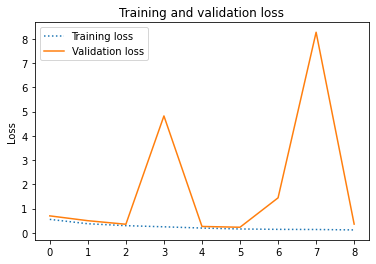

In [33]:
# Wykres prezentujący utratę treningu i utratę walidacji, stworzony w podobny sposób jak na zajęciach
plt.plot(history.history['loss'], label='Training loss', linestyle=':') 
plt.plot(history.history['val_loss'], label='Validation loss')          
plt.title('Training and validation loss')                               
plt.ylabel('Loss')                                                      
plt.legend()

In [34]:
# Dokładność i utrata oceny na zbiorze testowym
evaluation = model.evaluate(X_test, y_test)
print('\nDokładność na zbiorze testowym:')
print(evaluation[1])
print('\nUtrata oceny na zbiorze testowym:')
print(evaluation[0])

79/79 [==============================] - 4s 49ms/step - loss: 0.4108 - accuracy: 0.8672

Dokładność na zbiorze testowym:
0.8672000169754028

Utrata oceny na zbiorze testowym:
0.4108288586139679


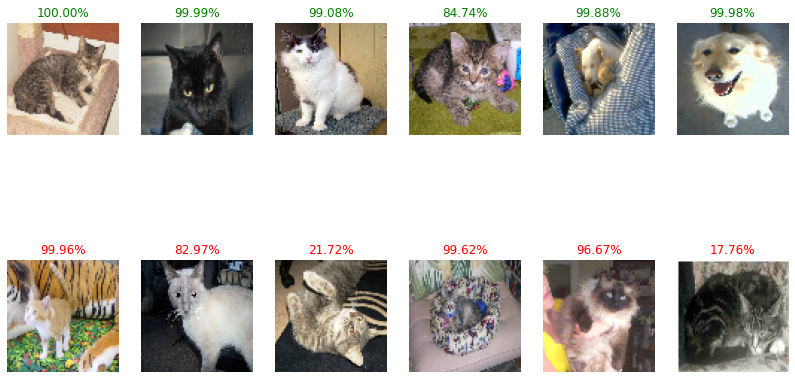

In [36]:
# Na podstawie kodu z zajęć wyrywowano zdjęcia prawidłowo i źle ocenione razem z ich prawdopodobieństwem
predictions = model.predict(X_test)      
correct = np.round(predictions).ravel() == y_test  
incorrect_pred = np.where(correct == 0)[0]  
correct_pred = np.where(correct)[0]         
confidence = np.abs(predictions.ravel() - 0.5) * 2                                              
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(14, 8))       
ax = ax.ravel()

for idx in range(6):
    img_idx = correct_pred[idx]
    ax[idx].imshow(X_test[img_idx]/255)                         
    ax[idx].set_title('{:.2f}%'.format(confidence[img_idx]*100), color='green') 
    ax[idx].axis('off')
for index in range(6):
    img = incorrect_pred[index]
    ax[index+6].imshow(X_test[img]/255)
    ax[index+6].set_title('{:.2f}%'.format(confidence[img]*100), color='red')
    ax[index+6].axis('off')

In [44]:
# Tworzenie zbioru z nowymi zdjęciami:
new_images = os.listdir('images')
full_path = [os.path.join('images', img) for img in new_images]
X_2 = list()
y_2 = np.array(['pies' in img for img in new_images])
for image in full_path:
    new_img = img_to_array(load_img(image, target_size=(75, 75, 3)))
    X_2.append(new_img)
X_2 = np.stack(X_2, axis=0)
    

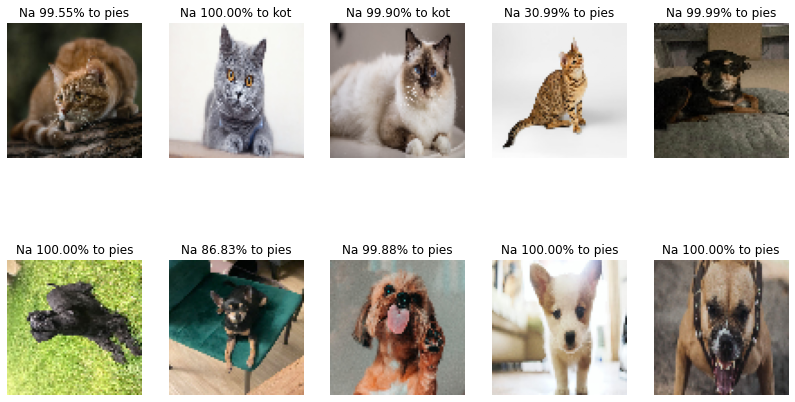

In [53]:
# Przedstawienie nowych obrazków z etykietą nadaną przez model i jego pewnością:
predictions2 = model.predict(X_2)                 
confidence2 = np.abs(predictions2.ravel() - 0.5) * 2
labels = []                                           
for i in predictions2:
    if i > 0.5:
        labels.append('pies')
    else:
        labels.append('kot')                                              
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(14, 8))       
ax = ax.ravel()

for j in range(10):
    ax[j].imshow(X_2[j]/255)
    ax[j].set_title('Na {:.2f}% to {}'.format(confidence2[j]*100, labels[j]), color = 'black')
    ax[j].axis('off')

In [54]:
# Zapisywanie modelu
model.save('WISZNIEWSKI_JAKUB_58346_MODEL.h5')